# An analysis of our electrical consumption
## Hypothesis:
1. Consumption is higher on weekend vs weekdays
1. Sunshine days will have less net consumption (leverage different data frame)
1. Winter months (due to lower sunshine hours) will have higher net consumption than summer months

## Questions: 
1. Would a battery make any difference and if so, then how much?
1. Are there months/days that the battery would not get used


## Ideas
1. Count the amount of 0 net consumption per day 

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#consumption = pd.read_csv('../data/elforbrug/elforbrug_2020_2021.csv',delimiter=';',parse_dates=['Fradato'], decimal=',')
consumption = pd.read_csv('../data/elforbrug/Meterdata.csv',delimiter=';',parse_dates=['Fradato'], decimal=',')
consumption['HourOfDay'] = consumption['Fradato'].dt.hour
consumption['Month'] = consumption['Fradato'].dt.month
consumption.tail()

,Fradato,Tildato,Forbrug,HourOfDay,Month
14201,2021-04-10 19:00:00,04-10-2021 20:00,0.38,19,4
14202,2021-04-10 20:00:00,04-10-2021 21:00,0.39,20,4
14203,2021-04-10 21:00:00,04-10-2021 22:00,0.35,21,4
14204,2021-04-10 22:00:00,04-10-2021 23:00,0.33,22,4
14205,2021-04-10 23:00:00,05-10-2021 00:00,0.26,23,4


# Look at hour of day for consumption trends

## Visualise consumption distribution for a single hour slice of the day

<AxesSubplot:xlabel='Forbrug', ylabel='Density'>

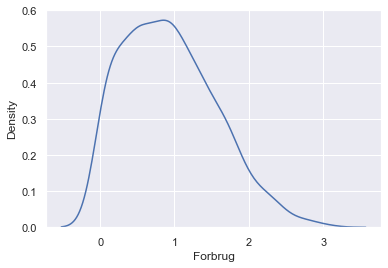

In [11]:
singlesliceofday = consumption[consumption['HourOfDay'] == 17]
sns.kdeplot(data=singlesliceofday, x='Forbrug')

### Trying to make a ridgeplot
This is to see the dispertion of consumption for each hour slice. Hours 3 & 4 have two destinct peaks that might be worth understanding.

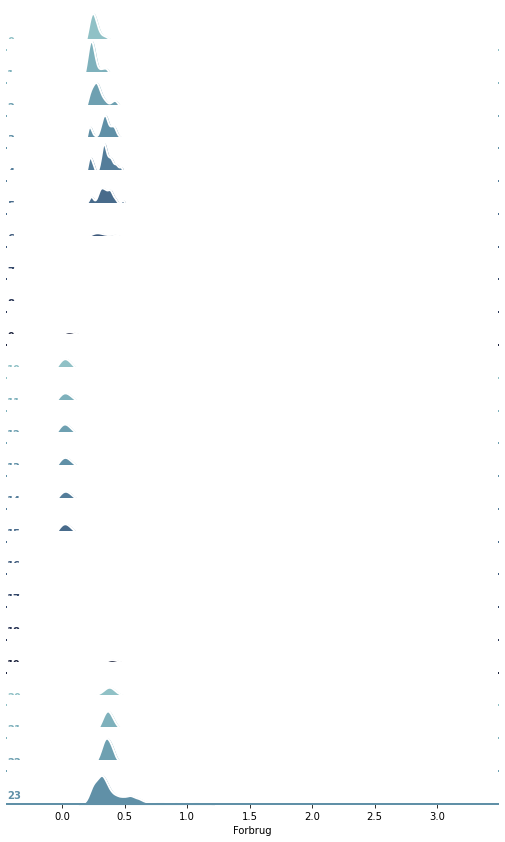

In [3]:
#https://seaborn.pydata.org/examples/kde_ridgeplot.html
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(consumption, row='HourOfDay', hue='HourOfDay', aspect=15, height=.5, palette=pal)

# g.map(sns.kdeplot, "x", bw_adjust=.5, clip_on=False,fill=True, alpha=1, linewidth=1.5)
#sns.kdeplot(data=singlesliceofday, x='Forbrug')
g.map(sns.kdeplot, 'Forbrug', bw_adjust=.5, clip_on=False,fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'Forbrug', clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'Forbrug')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

Do the same with Violin for higher fidelity?

## Understanding how share of consumption is split by day (for all days)

<AxesSubplot:ylabel='HourOfDay'>

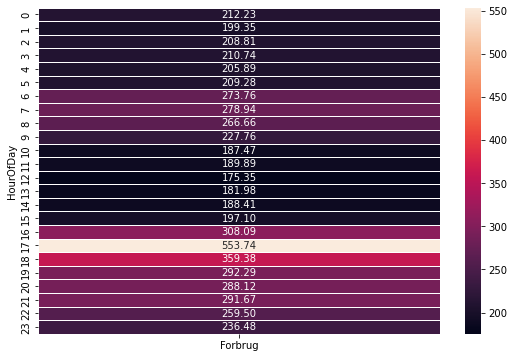

In [4]:
aggrPerHour = consumption.pivot_table(index = ['HourOfDay'], values = 'Forbrug', aggfunc=np.sum )
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(aggrPerHour, annot=True, fmt='.2f', linewidths=.5, ax=ax)

## Show heatmap of consumption split on day of week (0 = Monday) and hour of day
Here showing average

<AxesSubplot:xlabel='DayOfWeek', ylabel='HourOfDay'>

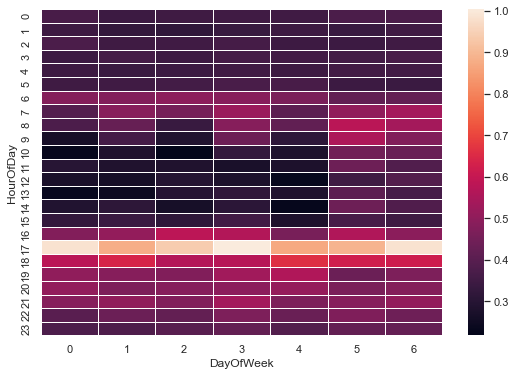

In [5]:

sns.set_theme(style="darkgrid")

#Annotate day of week
consumption['NamedDayOfWeek'] = consumption['Fradato'].dt.day_name()
consumption['DayOfWeek'] = consumption['Fradato'].dt.dayofweek

conspivot = consumption.pivot_table(index = ['HourOfDay'], columns =['DayOfWeek'], values = 'Forbrug', aggfunc=np.average )

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(conspivot, annot=False, fmt='f', linewidths=.5, ax=ax)

Here showing aggregate value

<AxesSubplot:xlabel='DayOfWeek', ylabel='HourOfDay'>

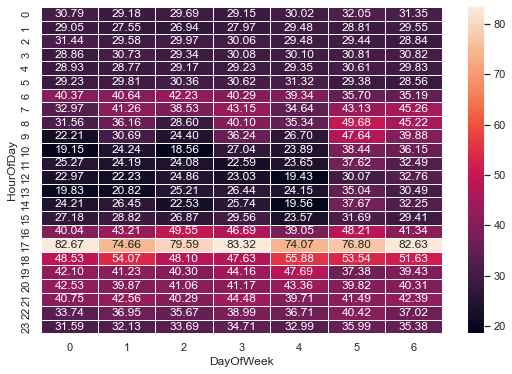

In [6]:
conspivot = consumption.pivot_table(index = ['HourOfDay'], columns =['DayOfWeek'], values = 'Forbrug', aggfunc=np.sum )

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(conspivot, annot=True, fmt='.2f', linewidths=.5, ax=ax)

That was sad. :-(


# Now looking for spots with ZERO net consumption
This is what we are here for! 

In [7]:
zeroCons = consumption[consumption['Forbrug'] == 0]

print('There are ' + str(len(zeroCons.index)) + ' hour slices with **ZERO** net consumption!!!')
print('That is ' + str(len(zeroCons.index)/len(consumption.index)*100) + '% !!!')

There are 410 hour slices with **ZERO** net consumption!!!
That is 2.8861044629029986% !!!


Lets look at when they fall

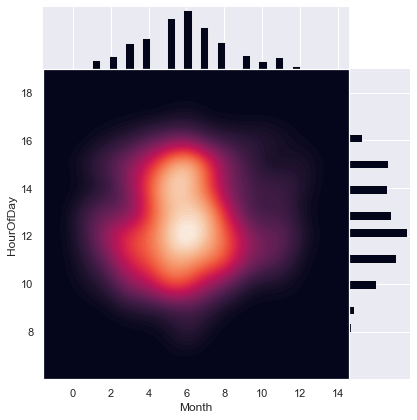

In [8]:
#https://seaborn.pydata.org/examples/smooth_bivariate_kde.html

g = sns.JointGrid(data=zeroCons, x='Month', y='HourOfDay', space=0)
g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

What does the consumption look like just after these famed **ZERO** consumption periods? 

If they are low then maybe a battery could tide us over and save us some money! 

## Let's look at almost zero consumption
Maybe there are many more?

There are 2125 hour-slices with less than 100W net consumption!!!
That is 14.95846825285091% !!!


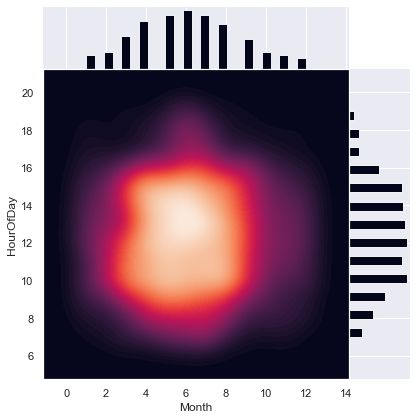

In [12]:
almostzero = consumption[consumption['Forbrug'] < 0.1]
print('There are ' + str(len(almostzero.index)) + ' hour-slices with less than 100W net consumption!!!')
print('That is ' + str(len(almostzero.index)/len(consumption.index)*100) + '% !!!')

g = sns.JointGrid(data=almostzero, x='Month', y='HourOfDay', space=0)
g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)